## Content
* Data ingestion
    * Remove outliers
    * Remove adoption features not in ABM
    * Data splitting for CV
* Features preparation
    * Pipeline preparation
    * Features names collection
* Model selection
    * Functions for models results
    * Functions for models' error analyis
    * Models training
    * Results
* Final models tuning and training

In [38]:
import numpy as np
import pandas as pd
import math
import joblib
import os

In [39]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from 'C:\\Users\\giaco\\pcf-project\\ml_models\\custom_transformers.py'>

In [40]:
from custom_transformers import (
    TransformAdoptionFeatures,
    TransformCensusFeatures, 
    TransformClimateFeatures,
    TransformSoilFeatures,
    TransformEconomicFeatures,
)

In [41]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [42]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
 # How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=10)

# Data ingestion

In [44]:
path_to_dataset = "Municipalities final dataset for analysis.csv"

In [45]:
dataset_original = pd.read_csv(path_to_dataset, index_col=['Municipality', 'Year'])

In [46]:
# Remove features with 0 adoption to obtain the regression dataset
mask_no_adoption = dataset_original['adoption_in_year'] < 0.0000001
dataset_original = dataset_original.drop(dataset_original.loc[mask_no_adoption].index)
len(dataset_original)

2466

In [47]:
# Remove outliers adoption_in_year
outliers = dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([(    'Vagos', 2007),
            (    'Vagos', 2008),
            (    'Tomar', 2005),
            ('Alcochete', 2010),
            ('Alcochete', 2011),
            ('Alcochete', 2012)],
           names=['Municipality', 'Year'])


In [48]:
# Remove outliers cumul_adoption_10_y_pr_y_munic
outliers = dataset_original.loc[dataset_original['tot_cumul_adoption_pr_y_munic'] > 0.4].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Tomar', 2003),
            ('Tomar', 2004),
            ('Tomar', 2006),
            ('Tomar', 2007),
            ('Tomar', 2008)],
           names=['Municipality', 'Year'])


In [49]:
dataset_original.shape

(2455, 45)

In [50]:
dataset = dataset_original.reset_index(drop=True)

### Create a mapping of each new instance to municipality and year it's referring to

In [51]:
map_instances_to_munic_year = dict(zip(dataset.index, dataset_original.index))

## Final number of instances and features

In [52]:
dataset.shape

(2455, 45)

## Copy the data splitting label and features

In [53]:
dataset_labels = dataset['adoption_in_year'].copy()
dataset = dataset.drop('adoption_in_year', axis=1)

In [54]:
dataset_labels.describe()

count   2455.000000
mean       0.004670
std        0.008587
min        0.000009
25%        0.000862
50%        0.002012
75%        0.004817
max        0.100604
Name: adoption_in_year, dtype: float64

## Split for cross-validation

Split used in all the cross-validation, stratified based on the number of data points before the PCF project and during it

In [55]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit

First, generate the feature to split, the year of the instance

In [56]:
dataset_split = dataset_original.copy()

In [57]:
years = dataset_split.index.get_level_values(1).to_list()
dataset_split['Year'] = years

Second, get for each instance the test fold it has to belong to based on the split based on the created category

In [58]:
n_folds = 3
strat_split = StratifiedKFold(n_splits=n_folds, shuffle=True)

In [59]:
test_indexes = np.zeros(len(dataset_split))
fold = 0
for _, test_index in strat_split.split(dataset_split, dataset_split['Year']):
    for i in test_index:
        test_indexes[i] = fold
    fold += 1

Third, pass to the list of test folds indexes to generate the PredefinedSplit

In [60]:
cv_split = PredefinedSplit(test_indexes)

In [61]:
# Check ratio is kept
ratio_PCF_dataset = len(dataset_split.loc[(slice(None), [2007]), :]) / len(dataset_split)
test_set = dataset_split.iloc[np.where(test_indexes==1)]
ratio_PCF_test_set = len(test_set.loc[(slice(None), [2007]), :]) / len(test_set)
print(ratio_PCF_dataset, ratio_PCF_test_set)

0.07454175152749491 0.0745721271393643


# Features preparation

## Features names collection

### Pre-transformation

In [62]:
features_original = [feat for feat in dataset.columns]

In [63]:
features_adoption = [feat for feat in features_original if 'adoption' in feat]
features_climate = [feat for feat in features_original if '_t_' in feat or '_prec_' in feat]
features_soil = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features_economic = ['sbp_payment']

features_not_census = (features_adoption + features_climate + features_soil + features_economic)
features_census = [feat for feat in features_original if feat not in features_not_census]

In [64]:
len(features_census) + len(features_not_census)

44

### Post-transformation

In [66]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(), TransformCensusFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features = features + features_ind

In [67]:
len(features)

19

#### With squared cumulative adoption

In [68]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(add_square_cumul_adoption=True),
                TransformCensusFeatures(), TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features_sq = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features_sq = features_sq + features_ind

In [69]:
len(features_sq)

20

## Preparation pipeline

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [71]:
transformation_pipeline = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(), features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

dataset_transf = transformation_pipeline.fit_transform(dataset)

In [72]:
full_pipeline_stand = Pipeline([
    ('transformation', transformation_pipeline),
    ('scaling', StandardScaler())
])

In [73]:
dataset_prepared_stand = full_pipeline_stand.fit_transform(dataset)

In [36]:
dataset_prepared_stand.shape

(2455, 19)

In [37]:
# Print prepared data as a DataFrame
pd.DataFrame(dataset_prepared_stand, columns=features, index=dataset.index).head()

,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_mean,educ_second_super,farmers_over65,inc_mainly_ext,educ_none,work_unit_100ha,agric_area_owned,lu_per_agric_area,av_d_mean_t_average_munic,av_d_max_t_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,sbp_payment
0,-0.541092,-1.111866,-0.463252,-0.537419,-1.137719,-1.875770,-0.185129,0.597305,1.863707,-1.136328,0.498686,-1.169738,-0.947620,-1.004479,-0.482743,1.317392,1.506530,0.156634,-0.306663
1,-0.516549,-1.050977,-0.442232,-0.534029,-1.124769,-1.821742,-0.137470,0.417110,1.780241,-1.101430,0.493610,-1.169738,-0.947620,-1.004479,-0.482743,1.317392,1.506530,0.156634,-0.306663
2,-0.496097,-0.804785,-0.400193,-0.526192,-1.098869,-1.696843,-0.037835,0.056720,1.613309,-1.028472,0.483456,-1.169738,-0.947620,-1.004479,-0.482743,1.317392,1.506530,0.156634,-0.306663
3,-0.483826,-0.516484,-0.327890,-0.515048,-1.034314,-1.542622,-0.025228,-0.116087,1.345339,-0.677691,0.390803,-1.169738,-0.947620,-1.004479,-0.482743,1.317392,1.506530,0.156634,-0.306663
4,-0.442922,-0.272147,-0.291738,-0.508850,-1.002036,-1.456854,-0.019121,-0.202491,1.211354,-0.507758,0.344476,-1.169738,-0.947620,-1.004479,-0.482743,1.317392,1.506530,0.156634,-0.306663


### With squared cumulative adoption

In [54]:
transformation_pipeline_sq = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(add_square_cumul_adoption=True),
     features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

In [55]:
full_pipeline_stand_sq = Pipeline([
    ('transformation', transformation_pipeline_sq),
    ('scaling', StandardScaler())
])

In [56]:
dataset_stand_sq_cum_ad = full_pipeline_stand_sq.fit_transform(dataset)

In [57]:
dataset_stand_sq_cum_ad.shape

(2455, 20)

# Model selection

* Linear regression with Elastic Net regularization
    * With squared cumulative adoption
    * Polynomial
* SVM
    * Linear
    * With squared cumulative adoption
    * Non-linear

In [43]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone

In [44]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [45]:
from scipy.stats import expon, uniform, reciprocal

## Functions for models results

In [46]:
cols = ['cv RMSE_mean', 'cv RMSE std', 'cv adjR2 mean', 'cv adjR2 std', 'train set RMSE', 'train set adjR2']
models_results = pd.DataFrame(columns=cols, dtype=np.float64)

In [47]:
def display_scores(scores, score_name):
    print('Cross-validation', score_name)
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    print('')

In [48]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [49]:
from sklearn.model_selection import KFold

def cross_val_rmse_r2(reg, dataset_prepared, cv_split):
    scores = cross_validate(reg, dataset_prepared, dataset_labels,
                            scoring=['neg_mean_squared_error', 'r2'], cv=cv_split)
    rmse_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2_scores = scores['test_r2']
    adj_r2_scores = adjusted_r2(r2_scores, (dataset_prepared.shape[0] // n_folds), dataset_prepared.shape[1])
    cv_scores = {'RMSE': rmse_scores, 'adjR2': adj_r2_scores}
    return cv_scores

In [50]:
def predict_train_set(reg, dataset_prepared):
    reg.fit(dataset_prepared, dataset_labels)
    predictions = reg.predict(dataset_prepared)
    mse = mean_squared_error(dataset_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(dataset_labels, predictions)
    adj_r2 = adjusted_r2(r2, dataset_prepared.shape[0], dataset_prepared.shape[1])
    print('Scores on training set')
    print('RMSE score:', rmse)
    print('Adjusted R2 score:', adj_r2)
    return (rmse, adj_r2)

In [51]:
def load_model_results(reg, reg_name, results_df, cv_scores, train_results):
    df_cols = results_df.columns
    
    # Add cv columns
    for score_name, score_values in cv_scores.items():
        col_mean = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('mean' in col)]
        col_std = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('std' in col)]
        results_df.loc[reg_name, col_mean] = score_values.mean()
        results_df.loc[reg_name, col_std] = score_values.std()
    # Add training set results columns
    cols_train = [col for col in df_cols if ('train' in col)]
    results_df.loc[reg_name, cols_train] = train_results

In [52]:
def test_regressor(reg, dataset_prepared, labels, reg_name=None, results_df=models_results, cv_split=cv_split):  
    """
    Function to:
    - train a regressor using cross validation, reporting both RMSE and adjusted R2 score
    - train a regressor on the training set, to check it for overfiting
    - load the model performances in a dataframe to keep all models results
    
    reg_name: how to report the model's results in the DataFrame with the results. If None, do not add it.
    """
    cv_scores = cross_val_rmse_r2(reg, dataset_prepared, cv_split)
    print("Cross validation scores")
    for score_name, score_value in cv_scores.items():
        display_scores(score_value, score_name)
    print("")

    train_results = predict_train_set(reg, dataset_prepared)
        
    if reg_name != None:
        load_model_results(reg, reg_name, results_df, cv_scores, train_results)

In [53]:
def get_grid_search_results(gs):
    best_est = gs.best_estimator_
    print("Best estimator:", best_est)
    print("Best parameters:", gs.best_params_)
    for scorer_name in gs.scorer_.keys():
        res_test = gs.cv_results_['mean_test_' + scorer_name][gs.best_index_]
        res_train = gs.cv_results_['mean_train_' + scorer_name][gs.best_index_]
        print("")
        print(scorer_name + ' mean on test sets:', res_test)
        print(scorer_name + ' mean on train sets:', res_train)

## Functions for models' analysis

In [54]:
def plot_validation_curves(estimator, param_name, param_values, scoring, dataset, labels):
    train_errors, val_errors = [], []
    for param in param_values:
        estimator.set_params(**{param_name:param})
        scores = cross_validate(estimator, dataset, labels, scoring=scoring, 
                                cv=cv_split, n_jobs=-1, return_train_score=True)
        train_errors.append(-scores['train_score'].mean())
        val_errors.append(-scores['test_score'].mean())

    plt.plot(val_errors, "b-", linewidth=2, label="Validation set")
    plt.plot(train_errors, "r--", linewidth=2, label="Training set")
    plt.legend(loc="upper right", fontsize=12)
    x = np.arange(0, len(param_values), 1)
    plt.xticks(x, np.round(param_values, 2))
    plt.xlabel(param_name + " value", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, fig_name=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    steps = np.arange(100, len(X_train), 100)
    for m in steps:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(steps, np.sqrt(train_errors), "r-+", linewidth=2, label="Training error")
    plt.plot(steps, np.sqrt(val_errors), "b-", linewidth=3, label="Validation error")
    plt.legend(loc="lower right", fontsize=13)   
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Root mean squared error", fontsize=14)
    
    if fig_name != None:
        save_fig((fig_name))

## Linear regression (elastic net)

In [308]:
from sklearn.linear_model import SGDRegressor

In [309]:
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

param_grid = {
    #"tol": [5e-3],
    #"max_iter": [10000],
    "alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_lin_reg = GridSearchCV(el_net_lin_reg, param_grid, cv=cv_split,
                            scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                            return_train_score=True, verbose=1)

srch_lin_reg.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    1.8s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
             estimator=SGDRegressor(learning_rate='adaptive',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [310]:
get_grid_search_results(srch_lin_reg)

Best estimator: SGDRegressor(alpha=0.1, l1_ratio=0.0, learning_rate='adaptive',
             penalty='elasticnet')
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.0}

neg_root_mean_squared_error mean on test sets: -0.006735652715236069
neg_root_mean_squared_error mean on train sets: -0.006617364194329058

r2 mean on test sets: 0.3743794487438949
r2 mean on train sets: 0.40206459938664746


In [311]:
lin_reg = srch_lin_reg.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0071828646 0.0060763936 0.0069696493]
Mean: 0.00674296917718219
Standard deviation: 0.00047931020164187333

Cross-validation adjR2
Scores: [0.343639584  0.3209116221 0.4101104098]
Mean: 0.35822053864617304
Standard deviation: 0.03784670053568197


Scores on training set
RMSE score: 0.006646752007238695
Adjusted R2 score: 0.394159299852771


### Second iteration

In [312]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_2 = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  1.1min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D5B3848>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D509D48>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [313]:
get_grid_search_results(srch_lin_reg_2)

Best estimator: SGDRegressor(alpha=0.018214044847171408, l1_ratio=9.343307831355396e-05,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.018214044847171408, 'l1_ratio': 9.343307831355396e-05, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.006734976367569336
neg_root_mean_squared_error mean on train sets: -0.006586304204902212

r2 mean on test sets: 0.3725942716449895
r2 mean on train sets: 0.407576636394726


In [314]:
lin_reg = srch_lin_reg_2.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels, 'Linear Regression')

Cross validation scores
Cross-validation RMSE
Scores: [0.00715707   0.006184041  0.0068609503]
Mean: 0.006734020451968477
Standard deviation: 0.00040725072911261393

Cross-validation adjR2
Scores: [0.3483452702 0.2966374779 0.4283668194]
Mean: 0.35778318912806245
Standard deviation: 0.05419077774752589


Scores on training set
RMSE score: 0.00661531401041517
Adjusted R2 score: 0.39987679159643863


## Linear Regression with squared cumulative adoption

In [315]:
from sklearn.linear_model import SGDRegressor
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

In [316]:
param_grid = {
    'max_iter': [3000],
    "alpha": uniform(0.001, 0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_sq = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_sq.fit(dataset_stand_sq_cum_ad, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  1.1min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D5B1F08>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D5B1948>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [317]:
get_grid_search_results(srch_lin_reg_sq)

Best estimator: SGDRegressor(alpha=0.010387867861964058, l1_ratio=4.205398655510173e-05,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.010387867861964058, 'l1_ratio': 4.205398655510173e-05, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.006643581501301008
neg_root_mean_squared_error mean on train sets: -0.006434725982117216

r2 mean on test sets: 0.3911239523215184
r2 mean on train sets: 0.43521630133115846


In [318]:
lin_reg_sq = srch_lin_reg_sq.best_estimator_
name = "Linear regression + cum_ad_sq"
test_regressor(lin_reg_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0071190945 0.0059461663 0.0068372762]
Mean: 0.00663417900046312
Standard deviation: 0.0004999176921725496

Cross-validation adjR2
Scores: [0.3544333164 0.3488918044 0.4315926244]
Mean: 0.37830591504412964
Standard deviation: 0.037747248289145115


Scores on training set
RMSE score: 0.006480631265784982
Adjusted R2 score: 0.4238274240680121


## Polynomial regression

In [319]:
from sklearn.preprocessing import PolynomialFeatures

In [320]:
poly_features = PolynomialFeatures(degree=2, include_bias=False) # Already added by Elastic Net

In [321]:
full_pipeline_stand_poly = Pipeline([
    ('transformation', transformation_pipeline),
    ('poly_features', poly_features),
    ('scaling', StandardScaler())
])

In [322]:
dataset_prepared_stand_poly = full_pipeline_stand_poly.fit_transform(dataset)

In [323]:
dataset_prepared_stand_poly.shape

(2454, 209)


### Hyperparameters search on polynomial regression with elastic net regularization

In [324]:
from sklearn.linear_model import SGDRegressor

el_net_pol_reg = SGDRegressor(penalty='elasticnet', learning_rate='optimal') # Optimal much faster and converging

param_grid = {
    "max_iter": [3000],
    "alpha": [0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_pol_reg = GridSearchCV(el_net_pol_reg, param_grid, cv=cv_split,
                                   scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                   return_train_score=True, verbose=1)

srch_pol_reg.fit(dataset_prepared_stand_poly, dataset_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider 

GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
             estimator=SGDRegressor(learning_rate='optimal',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': [3000]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [325]:
get_grid_search_results(srch_pol_reg)

Best estimator: SGDRegressor(alpha=0.1, l1_ratio=0.75, learning_rate='optimal', max_iter=3000,
             penalty='elasticnet')
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.75, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.008538704096182218
neg_root_mean_squared_error mean on train sets: -0.008565137253543817

r2 mean on test sets: -0.00016985823047292273
r2 mean on train sets: -7.24431159441578e-05


In [326]:
pol_reg = srch_pol_reg.best_estimator_
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [8.9713978295e-03 7.4630010512e-03 4.2161882702e+09]
Mean: 1405396090.0876048
Standard deviation: 1987530211.09639

Cross-validation adjR2
Scores: [-3.4389878683e-01 -3.4450002314e-01 -2.8332714728e+23]
Mean: -9.444238242578697e+22
Standard deviation: 1.3356169808937437e+23


Scores on training set
RMSE score: 0.008572823443172329
Adjusted R2 score: -0.09316312968730567


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



### Second iteration

In [327]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.01),
    "l1_ratio": uniform(0, 0.5),
    }

srch_pol_reg_2 = RandomizedSearchCV(el_net_pol_reg, param_grid, cv=cv_split, n_iter=100,
                                        scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                        return_train_score=True, verbose=1)

srch_pol_reg_2.fit(dataset_prepared_stand_poly, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analy

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=SGDRegressor(learning_rate='optimal',
                                          penalty='elasticnet'),
                   n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D81EAC8>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D81EBC8>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [328]:
get_grid_search_results(srch_pol_reg_2)

Best estimator: SGDRegressor(alpha=0.029840523924783487, l1_ratio=0.36950146211372226,
             learning_rate='optimal', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.029840523924783487, 'l1_ratio': 0.36950146211372226, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.008546271016301815
neg_root_mean_squared_error mean on train sets: -0.008568272608211207

r2 mean on test sets: -0.0021727584138045617
r2 mean on train sets: -0.0007669252944818942


In [329]:
pol_reg = srch_pol_reg_2.best_estimator_
name = 'Polynomial Regression'
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels, name)

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Cross validation scores
Cross-validation RMSE
Scores: [1.1785225598e+08 1.2773711565e+08 9.1834647274e-03]
Mean: 81863123.88245939
Standard deviation: 58026464.6541317

Cross-validation adjR2
Scores: [-2.3191141814e+20 -3.9388370945e+20 -3.4419204853e-01]
Mean: -2.085983758644466e+20
Standard deviation: 1.6164512075879052e+20


Scores on training set
RMSE score: 74404583.37506428
Adjusted R2 score: -8.234487880305122e+19


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



## Linear SVM

In [330]:
from sklearn.svm import LinearSVR

In [331]:
lin_svr = LinearSVR(max_iter=3000)

param_grid = {
    "epsilon": [0, 0.001, 0.01, 1],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"]
    }

srch_lin_svr = GridSearchCV(lin_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr.fit(dataset_prepared_stand, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed

GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
             estimator=LinearSVR(max_iter=3000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0, 0.001, 0.01, 1],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [332]:
get_grid_search_results(srch_lin_svr)

Best estimator: LinearSVR(C=0.01, epsilon=0, loss='squared_epsilon_insensitive', max_iter=3000)
Best parameters: {'C': 0.01, 'epsilon': 0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.006736401257048795
neg_root_mean_squared_error mean on train sets: -0.006587985922170483

r2 mean on test sets: 0.37271751418337784
r2 mean on train sets: 0.40730500769841704


In [333]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0071523686 0.0062182116 0.0068435882]
Mean: 0.00673805609903981
Standard deviation: 0.0003886001266431794

Cross-validation adjR2
Scores: [0.3492011314 0.2888430082 0.431256272 ]
Mean: 0.35643347053671093
Standard deviation: 0.058364455372327304


Scores on training set
RMSE score: 0.0066132995885728315
Adjusted R2 score: 0.4002422216384929


### Second iteration

In [334]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.9s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=LinearSVR(C=0.01, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932C2A97C8>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932C2DA2C8>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [335]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels, 'Linear SVM')

Cross validation scores
Cross-validation RMSE
Scores: [0.0071596188 0.0062368827 0.0068515078]
Mean: 0.006749336444547618
Standard deviation: 0.0003835706955308113

Cross-validation adjR2
Scores: [0.3478810461 0.2845658732 0.429939179 ]
Mean: 0.3541286994207972
Standard deviation: 0.05951260030185549


Scores on training set
RMSE score: 0.006613492543974073
Adjusted R2 score: 0.4002072230150402


## Linear SVM with squared cumulative adoption

In [336]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_sq_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_sq_2.fit(dataset_stand_sq_cum_ad, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.5s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=LinearSVR(C=0.01, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932C272148>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932C2B5108>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [337]:
get_grid_search_results(srch_lin_svr_sq_2)

Best estimator: LinearSVR(C=0.10160375227044234, loss='squared_epsilon_insensitive',
          max_iter=3000)
Best parameters: {'C': 0.10160375227044234, 'epsilon': 0.0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.0066478907770079025
neg_root_mean_squared_error mean on train sets: -0.0064209755137952995

r2 mean on test sets: 0.39097892454764377
r2 mean on train sets: 0.43764032968928607


In [338]:
lin_svr_sq = srch_lin_svr_sq_2.best_estimator_
name = "Linear SVM + cum_ad_sq"
test_regressor(lin_svr_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0071252287 0.0059629713 0.0068568384]
Mean: 0.0066483461468028705
Standard deviation: 0.0004968650349574662

Cross-validation adjR2
Scores: [0.3533203372 0.3452062709 0.4283354185]
Mean: 0.3756206755392768
Standard deviation: 0.0374218529142985


Scores on training set
RMSE score: 0.006467180178727934
Adjusted R2 score: 0.4262167297157682


## Non-linear SVM

In [65]:
from sklearn.svm import SVR

### GridSearchCV

In [340]:
from sklearn.model_selection import KFold

In [341]:
nl_svr = SVR()

param_grid = {
    "degree": [2, 3],
    "epsilon": [0.0001, 0.001, 0.1],
    "C": [0.001, 0.01, 0.1, 1],
    "gamma": [0.001, 0.01, 0.1, 1],
    }
 
srch_nl_svr = GridSearchCV(nl_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.2min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'degree': [2, 3],
                         'epsilon': [0.0001, 0.001, 0.1],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [342]:
get_grid_search_results(srch_nl_svr)

Best estimator: SVR(C=1, degree=2, epsilon=0.001, gamma=0.01)
Best parameters: {'C': 1, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.01}

neg_root_mean_squared_error mean on test sets: -0.0056910120874215
neg_root_mean_squared_error mean on train sets: -0.004719128205937342

r2 mean on test sets: 0.5512812642694466
r2 mean on train sets: 0.6939638613744711


In [343]:
best_nl_svr = srch_nl_svr.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0063525623 0.0051535598 0.0055669141]
Mean: 0.0056910120874215
Standard deviation: 0.0004972940046909038

Cross-validation adjR2
Scores: [0.4866129737 0.5115173542 0.6236621267]
Mean: 0.5405974848472906
Standard deviation: 0.05960904900374783


Scores on training set
RMSE score: 0.004900065456856112
Adjusted R2 score: 0.6707367519618634


### Second iteration

In [344]:
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.001),
    "C": expon(scale = 0.1),
    "gamma": expon(scale=0.01)
    }

srch_nl_svr_2 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=300,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.6min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=SVR(), n_iter=300,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D4AE7C8>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932C266E08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D4AED88>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [345]:
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=0.21924317209888344, degree=2, epsilon=0.001498693203906527,
    gamma=0.015252733393976271)
Best parameters: {'C': 0.21924317209888344, 'degree': 2, 'epsilon': 0.001498693203906527, 'gamma': 0.015252733393976271}

neg_root_mean_squared_error mean on test sets: -0.005536364225129563
neg_root_mean_squared_error mean on train sets: -0.00483302225734271

r2 mean on test sets: 0.574020889324564
r2 mean on train sets: 0.6796019941457532


In [346]:
best_nl_svr = srch_nl_svr_2.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0062519135 0.0050505094 0.0053066698]
Mean: 0.005536364225129563
Standard deviation: 0.0005166640691573812

Cross-validation adjR2
Scores: [0.5027521162 0.5308574126 0.6580260598]
Mean: 0.5638785295465775
Standard deviation: 0.06755390447879593


Scores on training set
RMSE score: 0.004971471481087549
Adjusted R2 score: 0.6610704774869071


### Third iteration

In [347]:
get_grid_search_results(srch_nl_svr)
print("")
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=1, degree=2, epsilon=0.001, gamma=0.01)
Best parameters: {'C': 1, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.01}

neg_root_mean_squared_error mean on test sets: -0.0056910120874215
neg_root_mean_squared_error mean on train sets: -0.004719128205937342

r2 mean on test sets: 0.5512812642694466
r2 mean on train sets: 0.6939638613744711

Best estimator: SVR(C=0.21924317209888344, degree=2, epsilon=0.001498693203906527,
    gamma=0.015252733393976271)
Best parameters: {'C': 0.21924317209888344, 'degree': 2, 'epsilon': 0.001498693203906527, 'gamma': 0.015252733393976271}

neg_root_mean_squared_error mean on test sets: -0.005536364225129563
neg_root_mean_squared_error mean on train sets: -0.00483302225734271

r2 mean on test sets: 0.574020889324564
r2 mean on train sets: 0.6796019941457532


In [348]:
from sklearn.svm import SVR
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.0017),
    "C": expon(scale = 0.26),
    "gamma": expon(scale=0.004)
    }
 
srch_nl_svr_3 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=500,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)
srch_nl_svr_3.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  5.7min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([1, 2, ..., 0, 0])),
                   estimator=SVR(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D3FAA88>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001932D3FAD08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019328D2B448>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [349]:
get_grid_search_results(srch_nl_svr_3)

Best estimator: SVR(C=0.2275294164785715, degree=2, epsilon=0.001444560800690858,
    gamma=0.013923995341641831)
Best parameters: {'C': 0.2275294164785715, 'degree': 2, 'epsilon': 0.001444560800690858, 'gamma': 0.013923995341641831}

neg_root_mean_squared_error mean on test sets: -0.005533716980725312
neg_root_mean_squared_error mean on train sets: -0.004886283421268075

r2 mean on test sets: 0.5748707867412087
r2 mean on train sets: 0.672644591297317


In [350]:
best_nl_svr = srch_nl_svr_3.best_estimator_
name = "Non-linear SVM"
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.006247487  0.0050246403 0.0053290236]
Mean: 0.005533716980725312
Standard deviation: 0.0005197839758248799

Cross-validation adjR2
Scores: [0.5034559909 0.5356510686 0.6551389284]
Mean: 0.5647486626159993
Standard deviation: 0.0652529992354464


Scores on training set
RMSE score: 0.005022492936261565
Adjusted R2 score: 0.6540780151688497


# Models summary

In [351]:
dataset_labels.describe()

count   2454.000000
mean       0.004660
std        0.008574
min        0.000009
25%        0.000861
50%        0.002011
75%        0.004810
max        0.100604
Name: adoption_in_year, dtype: float64

In [354]:
models_results

,cv RMSE_mean,cv RMSE std,cv adjR2 mean,cv adjR2 std,train set RMSE,train set adjR2
Linear Regression,0.006734,0.000407,0.357783,0.054191,0.006615,0.399877
Linear regression + cum_ad_sq,0.006634,0.000500,0.378306,0.037747,0.006481,0.423827
Polynomial Regression,81863123.882459,58026464.654132,-208598375864446615552.000000,161645120758790520832.000000,74404583.375064,-82344878803051216896.000000
Linear SVM,0.006749,0.000384,0.354129,0.059513,0.006613,0.400207
Linear SVM + cum_ad_sq,0.006648,0.000497,0.375621,0.037422,0.006467,0.426217
Non-linear SVM,0.005534,0.000520,0.564749,0.065253,0.005022,0.654078


In [355]:
models_results[['cv RMSE_mean', 'cv adjR2 mean', 'train set RMSE', 'train set adjR2']]

,cv RMSE_mean,cv adjR2 mean,train set RMSE,train set adjR2
Linear Regression,0.006734,0.357783,0.006615,0.399877
Linear regression + cum_ad_sq,0.006634,0.378306,0.006481,0.423827
Polynomial Regression,81863123.882459,-208598375864446615552.000000,74404583.375064,-82344878803051216896.000000
Linear SVM,0.006749,0.354129,0.006613,0.400207
Linear SVM + cum_ad_sq,0.006648,0.375621,0.006467,0.426217
Non-linear SVM,0.005534,0.564749,0.005022,0.654078


# Final models tuning and training
Using the Optuna library for Bayesian Optimization

In [65]:
from sklearn.model_selection import cross_val_score 
import optuna 
from optuna.samplers import TPESampler

In [66]:
from sklearn.svm import SVR

In [69]:
X = dataset_prepared_stand

def objective(trial):
    # Define the search space
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    C = trial.suggest_loguniform('C', 0.01, 10)
    gamma = trial.suggest_loguniform('gamma', 0.001, 1)
    epsilon = trial.suggest_loguniform('epsilon', 0.001, 1)

    reg = SVR(degree=2,
              kernel=kernel,
              C=C,
              gamma=gamma,
              epsilon=epsilon)
    score = cross_val_score(reg, X, dataset_labels, scoring='neg_root_mean_squared_error',
                            cv=cv_split).mean()

    return score

In [70]:
study_nl_svm_all = optuna.create_study(study_name="nl_svr_optimization_all",
                                        direction="maximize",
                                        sampler=TPESampler())

[I 2021-06-25 13:54:28,596] A new study created in memory with name: nl_svr_optimization_all


In [71]:
%%time
# pass the objective function to method optimize()

study_nl_svm_all.optimize(objective, n_trials=2000)

[I 2021-06-25 13:54:29,506] Trial 0 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 2.401128893225122, 'gamma': 0.2593831565309103, 'epsilon': 0.0533239374800341}. Best is trial 0 with value: -0.04522358590646345.
[I 2021-06-25 13:54:29,530] Trial 1 finished with value: -0.02647809014767386 and parameters: {'kernel': 'poly', 'C': 0.015358388961355272, 'gamma': 0.08097258264155258, 'epsilon': 0.032186021748580027}. Best is trial 1 with value: -0.02647809014767386.
[I 2021-06-25 13:54:29,542] Trial 2 finished with value: -0.04522358590646345 and parameters: {'kernel': 'poly', 'C': 0.5229960452425678, 'gamma': 0.004351932156104482, 'epsilon': 0.06987201582080166}. Best is trial 1 with value: -0.02647809014767386.
[I 2021-06-25 13:54:29,840] Trial 3 finished with value: -0.006049980217274092 and parameters: {'kernel': 'rbf', 'C': 0.9319173197321826, 'gamma': 0.008468930511651575, 'epsilon': 0.005080100787276004}. Best is trial 3 with value: -0.0060499802172

[I 2021-06-25 13:55:03,965] Trial 31 finished with value: -0.005804768099290998 and parameters: {'kernel': 'rbf', 'C': 6.6396513964376185, 'gamma': 0.0015682784800312075, 'epsilon': 0.002130506380137285}. Best is trial 21 with value: -0.005750873696786138.
[I 2021-06-25 13:55:04,827] Trial 32 finished with value: -0.005770530579322555 and parameters: {'kernel': 'rbf', 'C': 6.1176543113309725, 'gamma': 0.0010070073363422588, 'epsilon': 0.002031988675888125}. Best is trial 21 with value: -0.005750873696786138.
[I 2021-06-25 13:55:05,189] Trial 33 finished with value: -0.005975357389549345 and parameters: {'kernel': 'rbf', 'C': 2.534995022106643, 'gamma': 0.0010017920826202874, 'epsilon': 0.004112331243611389}. Best is trial 21 with value: -0.005750873696786138.
[I 2021-06-25 13:55:05,777] Trial 34 finished with value: -0.006308774716899743 and parameters: {'kernel': 'poly', 'C': 6.0619663835335595, 'gamma': 0.00332377776076797, 'epsilon': 0.001709084466621925}. Best is trial 21 with valu

[I 2021-06-25 13:55:24,261] Trial 62 finished with value: -0.005799724832675089 and parameters: {'kernel': 'rbf', 'C': 0.12944081862892037, 'gamma': 0.04098461534343172, 'epsilon': 0.0012933398760357278}. Best is trial 49 with value: -0.005734858275213892.
[I 2021-06-25 13:55:24,283] Trial 63 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.3855686830957684, 'gamma': 0.020946088013428572, 'epsilon': 0.11833712585396901}. Best is trial 49 with value: -0.005734858275213892.
[I 2021-06-25 13:55:24,804] Trial 64 finished with value: -0.005778399314168618 and parameters: {'kernel': 'rbf', 'C': 0.2656280550217142, 'gamma': 0.00923262567659147, 'epsilon': 0.0017604212507621282}. Best is trial 49 with value: -0.005734858275213892.
[I 2021-06-25 13:55:25,272] Trial 65 finished with value: -0.005799950800427971 and parameters: {'kernel': 'rbf', 'C': 0.059983749379198294, 'gamma': 0.015155973435800142, 'epsilon': 0.0010131351732912553}. Best is trial 49 with valu

[I 2021-06-25 13:55:38,148] Trial 93 finished with value: -0.0057177406008978235 and parameters: {'kernel': 'rbf', 'C': 0.08038027813096618, 'gamma': 0.028187838638562168, 'epsilon': 0.0016120972618016306}. Best is trial 75 with value: -0.005697586752871659.
[I 2021-06-25 13:55:38,529] Trial 94 finished with value: -0.005719309056744815 and parameters: {'kernel': 'rbf', 'C': 0.07517447100364884, 'gamma': 0.025329249102486573, 'epsilon': 0.0016116483556185216}. Best is trial 75 with value: -0.005697586752871659.
[I 2021-06-25 13:55:38,945] Trial 95 finished with value: -0.005725508661271069 and parameters: {'kernel': 'rbf', 'C': 0.07347633394093606, 'gamma': 0.0267448620851678, 'epsilon': 0.001715290711195823}. Best is trial 75 with value: -0.005697586752871659.
[I 2021-06-25 13:55:39,375] Trial 96 finished with value: -0.005723861065226865 and parameters: {'kernel': 'rbf', 'C': 0.0733007571226397, 'gamma': 0.024402195423892895, 'epsilon': 0.0017190949724739677}. Best is trial 75 with v

[I 2021-06-25 13:55:50,687] Trial 124 finished with value: -0.005737846479021705 and parameters: {'kernel': 'rbf', 'C': 0.07622314798049534, 'gamma': 0.04067056894354862, 'epsilon': 0.0017884721141173305}. Best is trial 98 with value: -0.0056835894708379435.
[I 2021-06-25 13:55:51,003] Trial 125 finished with value: -0.005707489280495082 and parameters: {'kernel': 'rbf', 'C': 0.12728806149373278, 'gamma': 0.02867240788668508, 'epsilon': 0.002153024913689371}. Best is trial 98 with value: -0.0056835894708379435.
[I 2021-06-25 13:55:51,309] Trial 126 finished with value: -0.0057023377411909324 and parameters: {'kernel': 'rbf', 'C': 0.12926551185511906, 'gamma': 0.026988905327867106, 'epsilon': 0.0021821687354879734}. Best is trial 98 with value: -0.0056835894708379435.
[I 2021-06-25 13:55:51,572] Trial 127 finished with value: -0.0057331997547148015 and parameters: {'kernel': 'rbf', 'C': 0.12577613359499915, 'gamma': 0.029680286464046975, 'epsilon': 0.002680404954065188}. Best is trial 9

[I 2021-06-25 13:56:05,616] Trial 155 finished with value: -0.00569216738088386 and parameters: {'kernel': 'rbf', 'C': 0.11473029589233164, 'gamma': 0.024886893789086272, 'epsilon': 0.0011986627017226649}. Best is trial 98 with value: -0.0056835894708379435.
[I 2021-06-25 13:56:06,115] Trial 156 finished with value: -0.0056736269798483355 and parameters: {'kernel': 'rbf', 'C': 0.15314711851215543, 'gamma': 0.02426309618814566, 'epsilon': 0.001386351000504121}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:06,617] Trial 157 finished with value: -0.005690413747171104 and parameters: {'kernel': 'rbf', 'C': 0.16125646850688993, 'gamma': 0.02561553456979716, 'epsilon': 0.001425713019203952}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:07,235] Trial 158 finished with value: -0.005876248007728557 and parameters: {'kernel': 'rbf', 'C': 0.2834514164953075, 'gamma': 0.03531289571469844, 'epsilon': 0.001383567803683102}. Best is trial 156 

[I 2021-06-25 13:56:21,240] Trial 185 finished with value: -0.005705295190063214 and parameters: {'kernel': 'rbf', 'C': 0.19043077239774098, 'gamma': 0.025933638532800382, 'epsilon': 0.0017631291756926187}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:21,768] Trial 186 finished with value: -0.005704509087278823 and parameters: {'kernel': 'rbf', 'C': 0.2212314877119836, 'gamma': 0.020873144376775784, 'epsilon': 0.0015445548056448966}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:22,313] Trial 187 finished with value: -0.00575804178738142 and parameters: {'kernel': 'rbf', 'C': 0.14981219192900008, 'gamma': 0.03350545828586889, 'epsilon': 0.0013293475039318637}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:22,686] Trial 188 finished with value: -0.00570090062562776 and parameters: {'kernel': 'rbf', 'C': 0.10621129878241256, 'gamma': 0.02358061979903542, 'epsilon': 0.0018027274874874274}. Best is trial 1

[I 2021-06-25 13:56:36,528] Trial 216 finished with value: -0.005807358985932039 and parameters: {'kernel': 'rbf', 'C': 0.23521977057381738, 'gamma': 0.029231287532727992, 'epsilon': 0.001482962229166614}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:37,060] Trial 217 finished with value: -0.005688993962432325 and parameters: {'kernel': 'rbf', 'C': 0.14363622294902942, 'gamma': 0.02384143287400765, 'epsilon': 0.0011584391106316428}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:37,722] Trial 218 finished with value: -0.005706636679515448 and parameters: {'kernel': 'rbf', 'C': 0.29962458195034614, 'gamma': 0.018838965718618005, 'epsilon': 0.0013041841876670797}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:38,206] Trial 219 finished with value: -0.005695419517161353 and parameters: {'kernel': 'rbf', 'C': 0.1794339586696002, 'gamma': 0.022389672228737743, 'epsilon': 0.0015883987256992518}. Best is trial

[I 2021-06-25 13:56:52,488] Trial 247 finished with value: -0.005703840482416709 and parameters: {'kernel': 'rbf', 'C': 0.10485708858796375, 'gamma': 0.027961869098874576, 'epsilon': 0.0011016392970226731}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:53,043] Trial 248 finished with value: -0.005696921879258121 and parameters: {'kernel': 'rbf', 'C': 0.14298555495356827, 'gamma': 0.020946410742997208, 'epsilon': 0.0012905167169441115}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:53,552] Trial 249 finished with value: -0.005687978473187763 and parameters: {'kernel': 'rbf', 'C': 0.12025140653425312, 'gamma': 0.025584536555035387, 'epsilon': 0.0015041883596840506}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:56:54,058] Trial 250 finished with value: -0.005698327839346671 and parameters: {'kernel': 'rbf', 'C': 0.11630615783248295, 'gamma': 0.027514208952280732, 'epsilon': 0.0013416144809827708}. Best is tr

[I 2021-06-25 13:57:07,121] Trial 278 finished with value: -0.005739540205207512 and parameters: {'kernel': 'rbf', 'C': 0.09516663517246264, 'gamma': 0.01968002865799194, 'epsilon': 0.0022466639276015857}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:07,771] Trial 279 finished with value: -0.005744680077556314 and parameters: {'kernel': 'rbf', 'C': 0.1598812414998977, 'gamma': 0.031523182100858305, 'epsilon': 0.0013044657381208673}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:08,515] Trial 280 finished with value: -0.005704415352832261 and parameters: {'kernel': 'rbf', 'C': 0.20919332579299618, 'gamma': 0.022809817961500015, 'epsilon': 0.001412905136293289}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:08,994] Trial 281 finished with value: -0.0057044860892270415 and parameters: {'kernel': 'rbf', 'C': 0.11619640894478042, 'gamma': 0.02785695334230703, 'epsilon': 0.001986648174476845}. Best is trial 

[I 2021-06-25 13:57:24,853] Trial 308 finished with value: -0.005689550656640774 and parameters: {'kernel': 'rbf', 'C': 0.14101385751444123, 'gamma': 0.021117066124969185, 'epsilon': 0.0012774341826650869}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:25,593] Trial 309 finished with value: -0.005741736550946871 and parameters: {'kernel': 'rbf', 'C': 0.2149616796726202, 'gamma': 0.027204416365998484, 'epsilon': 0.0015207671723503511}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:26,221] Trial 310 finished with value: -0.005685704150714006 and parameters: {'kernel': 'rbf', 'C': 0.17009801596564478, 'gamma': 0.024078984481936985, 'epsilon': 0.0017620713144847568}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:26,724] Trial 311 finished with value: -0.005701066776150224 and parameters: {'kernel': 'rbf', 'C': 0.1857427418464215, 'gamma': 0.02500930490653167, 'epsilon': 0.0021714975482442613}. Best is trial

[I 2021-06-25 13:57:42,439] Trial 339 finished with value: -0.005762608893316426 and parameters: {'kernel': 'rbf', 'C': 0.31266691124800844, 'gamma': 0.021261534225357186, 'epsilon': 0.0022822754660045594}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:43,112] Trial 340 finished with value: -0.0057253060908995556 and parameters: {'kernel': 'rbf', 'C': 0.14290307076765887, 'gamma': 0.02990656590266201, 'epsilon': 0.0011356299754519906}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:43,653] Trial 341 finished with value: -0.005723002286330832 and parameters: {'kernel': 'rbf', 'C': 0.21251925091310425, 'gamma': 0.025587830286320487, 'epsilon': 0.00163049724125849}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:57:44,159] Trial 342 finished with value: -0.005717922015263183 and parameters: {'kernel': 'rbf', 'C': 0.1639290465879172, 'gamma': 0.019295204624559935, 'epsilon': 0.001878438020105364}. Best is trial 

[I 2021-06-25 13:58:00,546] Trial 369 finished with value: -0.007618906324092429 and parameters: {'kernel': 'rbf', 'C': 0.1650556688946147, 'gamma': 0.035810303821345174, 'epsilon': 0.010434021145237442}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:01,094] Trial 370 finished with value: -0.005706296877987357 and parameters: {'kernel': 'rbf', 'C': 0.09687428430885596, 'gamma': 0.023354554953998668, 'epsilon': 0.0016444093243402286}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:01,550] Trial 371 finished with value: -0.005701874257732112 and parameters: {'kernel': 'rbf', 'C': 0.1322765762398749, 'gamma': 0.029103121392828758, 'epsilon': 0.0020289903933475295}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:01,588] Trial 372 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.15519939267242824, 'gamma': 0.02484582219048015, 'epsilon': 0.06889537493051892}. Best is trial 156

[I 2021-06-25 13:58:17,797] Trial 399 finished with value: -0.005707999594132638 and parameters: {'kernel': 'rbf', 'C': 0.12207728300684968, 'gamma': 0.019215814956333333, 'epsilon': 0.0014938926932495553}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:18,445] Trial 400 finished with value: -0.005743639981954332 and parameters: {'kernel': 'rbf', 'C': 0.1515583153776948, 'gamma': 0.01595884498977938, 'epsilon': 0.0010998361400015267}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:18,852] Trial 401 finished with value: -0.005708581868875589 and parameters: {'kernel': 'rbf', 'C': 0.13661363712772703, 'gamma': 0.02596412172574994, 'epsilon': 0.0018973744303333556}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:19,560] Trial 402 finished with value: -0.005704297052092726 and parameters: {'kernel': 'rbf', 'C': 0.17193858635964882, 'gamma': 0.02207083194388769, 'epsilon': 0.0010184895392526118}. Best is trial 

[I 2021-06-25 13:58:36,614] Trial 430 finished with value: -0.005714338874263751 and parameters: {'kernel': 'rbf', 'C': 0.08821725791488942, 'gamma': 0.03221834451693729, 'epsilon': 0.0014356467471409301}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:37,225] Trial 431 finished with value: -0.005731738982857993 and parameters: {'kernel': 'rbf', 'C': 0.12641725452769026, 'gamma': 0.018120155572958277, 'epsilon': 0.0012186361837282762}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:37,852] Trial 432 finished with value: -0.0056849262801798835 and parameters: {'kernel': 'rbf', 'C': 0.18839150492210208, 'gamma': 0.02422050211203797, 'epsilon': 0.0015394797785510878}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:38,541] Trial 433 finished with value: -0.005699347335213563 and parameters: {'kernel': 'rbf', 'C': 0.15865036682876246, 'gamma': 0.020145696194175177, 'epsilon': 0.0011211470113496355}. Best is tri

[I 2021-06-25 13:58:51,718] Trial 460 finished with value: -0.005701487758335639 and parameters: {'kernel': 'rbf', 'C': 0.1396788149688503, 'gamma': 0.027390132193926442, 'epsilon': 0.002134786851491571}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:52,152] Trial 461 finished with value: -0.005720252067552905 and parameters: {'kernel': 'rbf', 'C': 0.11329577888282047, 'gamma': 0.020063085968031386, 'epsilon': 0.0015681481122027043}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:52,656] Trial 462 finished with value: -0.005682019059077416 and parameters: {'kernel': 'rbf', 'C': 0.15970336779959496, 'gamma': 0.0246587515815197, 'epsilon': 0.0013765901525824773}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:58:53,247] Trial 463 finished with value: -0.0058238397267989656 and parameters: {'kernel': 'rbf', 'C': 0.19693197853401312, 'gamma': 0.032667614581308554, 'epsilon': 0.0011947125646449566}. Best is trial

[I 2021-06-25 13:59:07,346] Trial 490 finished with value: -0.00568687427306587 and parameters: {'kernel': 'rbf', 'C': 0.13636280560508277, 'gamma': 0.025001771412770844, 'epsilon': 0.001693580380917245}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:07,913] Trial 491 finished with value: -0.005694182298902479 and parameters: {'kernel': 'rbf', 'C': 0.15969446600396844, 'gamma': 0.019943025563345217, 'epsilon': 0.0012790426714483305}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:09,078] Trial 492 finished with value: -0.005718436400239534 and parameters: {'kernel': 'rbf', 'C': 0.18910760377708027, 'gamma': 0.016402292872944507, 'epsilon': 0.001000942037637517}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:09,545] Trial 493 finished with value: -0.005699833555064874 and parameters: {'kernel': 'rbf', 'C': 0.12041810219235641, 'gamma': 0.02867797532817861, 'epsilon': 0.0014707697198395814}. Best is trial 

[I 2021-06-25 13:59:26,529] Trial 521 finished with value: -0.005687949071442725 and parameters: {'kernel': 'rbf', 'C': 0.1069179186789572, 'gamma': 0.025215451174820262, 'epsilon': 0.0014973819082631623}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:27,068] Trial 522 finished with value: -0.005695653661706022 and parameters: {'kernel': 'rbf', 'C': 0.14267993701725293, 'gamma': 0.02394742308264999, 'epsilon': 0.002002922201488671}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:27,809] Trial 523 finished with value: -0.005700678235037134 and parameters: {'kernel': 'rbf', 'C': 0.12406480215647793, 'gamma': 0.027706312335324987, 'epsilon': 0.0011992214056295444}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:28,497] Trial 524 finished with value: -0.005681976614357755 and parameters: {'kernel': 'rbf', 'C': 0.14439738139973032, 'gamma': 0.022865910160812367, 'epsilon': 0.0014520642859051534}. Best is trial

[I 2021-06-25 13:59:44,219] Trial 552 finished with value: -0.005717077577884232 and parameters: {'kernel': 'rbf', 'C': 0.20302731430746163, 'gamma': 0.015905389421208067, 'epsilon': 0.001001870301738639}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:44,688] Trial 553 finished with value: -0.005696856701189017 and parameters: {'kernel': 'rbf', 'C': 0.15552597483452876, 'gamma': 0.021926329070935346, 'epsilon': 0.0016604257998053158}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:44,991] Trial 554 finished with value: -0.006438287135147526 and parameters: {'kernel': 'poly', 'C': 0.03014176203538101, 'gamma': 0.026097396238366, 'epsilon': 0.002376108817264578}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 13:59:45,624] Trial 555 finished with value: -0.005720886983825249 and parameters: {'kernel': 'rbf', 'C': 0.12682607498251602, 'gamma': 0.031014747995795792, 'epsilon': 0.0012140364491203977}. Best is trial 

[I 2021-06-25 14:00:08,839] Trial 583 finished with value: -0.0063094821187461335 and parameters: {'kernel': 'poly', 'C': 0.23502497302683545, 'gamma': 0.02411601257829348, 'epsilon': 0.0011875617590615607}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:09,391] Trial 584 finished with value: -0.005697723705596343 and parameters: {'kernel': 'rbf', 'C': 0.14456676059942794, 'gamma': 0.027697848323641642, 'epsilon': 0.0017945596439172995}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:09,925] Trial 585 finished with value: -0.005711655668117176 and parameters: {'kernel': 'rbf', 'C': 0.12114863479992741, 'gamma': 0.020403852297832453, 'epsilon': 0.0014897497645973267}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:10,601] Trial 586 finished with value: -0.005822816324594166 and parameters: {'kernel': 'rbf', 'C': 0.17269039857586732, 'gamma': 0.03575995880287137, 'epsilon': 0.0011287757738658046}. Best is tr

[I 2021-06-25 14:00:32,898] Trial 613 finished with value: -0.005704783886847611 and parameters: {'kernel': 'rbf', 'C': 0.2379916678031527, 'gamma': 0.016999917844530393, 'epsilon': 0.0013240021091358578}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:33,383] Trial 614 finished with value: -0.005692820870065094 and parameters: {'kernel': 'rbf', 'C': 0.134878815852331, 'gamma': 0.023913824727566892, 'epsilon': 0.0018122482535801098}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:33,965] Trial 615 finished with value: -0.0057505058817009375 and parameters: {'kernel': 'rbf', 'C': 0.1678969807737456, 'gamma': 0.031783971307032935, 'epsilon': 0.0015809131919112443}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:34,508] Trial 616 finished with value: -0.005689733739474514 and parameters: {'kernel': 'rbf', 'C': 0.146819428480514, 'gamma': 0.021516042085857515, 'epsilon': 0.0011326796051144606}. Best is trial 1

[I 2021-06-25 14:00:49,887] Trial 643 finished with value: -0.005733399540476361 and parameters: {'kernel': 'rbf', 'C': 0.1055971932312086, 'gamma': 0.03242036313385022, 'epsilon': 0.0010038548374732244}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:49,922] Trial 644 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.12630068383249984, 'gamma': 0.03999259250526477, 'epsilon': 0.19339146616505465}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:50,309] Trial 645 finished with value: -0.005802224029376948 and parameters: {'kernel': 'rbf', 'C': 0.1641831753401199, 'gamma': 0.018557493628488984, 'epsilon': 0.0031840532608251194}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:00:51,003] Trial 646 finished with value: -0.0057176059446980045 and parameters: {'kernel': 'rbf', 'C': 0.2283135134486298, 'gamma': 0.024782949270218787, 'epsilon': 0.001694724229316908}. Best is trial 156 

[I 2021-06-25 14:01:08,076] Trial 674 finished with value: -0.005753381136841502 and parameters: {'kernel': 'rbf', 'C': 0.21874927299217095, 'gamma': 0.013180127595896492, 'epsilon': 0.0016998501290005036}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:08,771] Trial 675 finished with value: -0.005708544171285613 and parameters: {'kernel': 'rbf', 'C': 0.15140266935577087, 'gamma': 0.026872481139944615, 'epsilon': 0.0011185654316821245}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:09,373] Trial 676 finished with value: -0.00569724802428283 and parameters: {'kernel': 'rbf', 'C': 0.17675904771160844, 'gamma': 0.018989056003367377, 'epsilon': 0.0013910127112895026}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:09,902] Trial 677 finished with value: -0.0057070791658801285 and parameters: {'kernel': 'rbf', 'C': 0.12735962857499128, 'gamma': 0.021261901681710032, 'epsilon': 0.0015560027491108494}. Best is tr

[I 2021-06-25 14:01:24,208] Trial 704 finished with value: -0.005697946638016174 and parameters: {'kernel': 'rbf', 'C': 0.11980374504938132, 'gamma': 0.028423590785094988, 'epsilon': 0.0015715460789918914}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:24,711] Trial 705 finished with value: -0.005734560048406993 and parameters: {'kernel': 'rbf', 'C': 0.1104807545253217, 'gamma': 0.014692221770662123, 'epsilon': 0.0013596564165923582}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:25,143] Trial 706 finished with value: -0.00569246300857584 and parameters: {'kernel': 'rbf', 'C': 0.12531025194825474, 'gamma': 0.024167099780241657, 'epsilon': 0.001662035408399209}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:25,672] Trial 707 finished with value: -0.005755725972848701 and parameters: {'kernel': 'rbf', 'C': 0.1355135186485481, 'gamma': 0.035467082169932614, 'epsilon': 0.0013592048744327124}. Best is trial 

[I 2021-06-25 14:01:40,952] Trial 735 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.1483266495982549, 'gamma': 0.029266808465517123, 'epsilon': 0.061801372664493016}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:41,000] Trial 736 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.12157833917250167, 'gamma': 0.01859169424333858, 'epsilon': 0.14715738752377064}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:41,588] Trial 737 finished with value: -0.005718022381506901 and parameters: {'kernel': 'rbf', 'C': 0.08960290505679702, 'gamma': 0.021717695101766674, 'epsilon': 0.0014951340296160682}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:01:42,416] Trial 738 finished with value: -0.0058056527174684056 and parameters: {'kernel': 'rbf', 'C': 0.1689042160090861, 'gamma': 0.03516898927166089, 'epsilon': 0.0012563031866288064}. Best is trial 156 

[I 2021-06-25 14:02:00,673] Trial 766 finished with value: -0.005815260982821483 and parameters: {'kernel': 'rbf', 'C': 0.15568410126267404, 'gamma': 0.038983915890234956, 'epsilon': 0.0020954269431711116}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:01,478] Trial 767 finished with value: -0.005733738614385413 and parameters: {'kernel': 'rbf', 'C': 0.13146751866536857, 'gamma': 0.030850775279133994, 'epsilon': 0.001000007195087766}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:01,983] Trial 768 finished with value: -0.005742425098648866 and parameters: {'kernel': 'rbf', 'C': 0.09265672572760837, 'gamma': 0.01648921845222965, 'epsilon': 0.0016237022520041871}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:02,740] Trial 769 finished with value: -0.005708700433516234 and parameters: {'kernel': 'rbf', 'C': 0.19419088825913602, 'gamma': 0.025274387834642358, 'epsilon': 0.001302863326862273}. Best is trial

[I 2021-06-25 14:02:17,889] Trial 797 finished with value: -0.005715572470193618 and parameters: {'kernel': 'rbf', 'C': 0.15412449099148767, 'gamma': 0.024174430147222287, 'epsilon': 0.002513019885226423}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:18,442] Trial 798 finished with value: -0.005755747086357697 and parameters: {'kernel': 'rbf', 'C': 0.17681282851983038, 'gamma': 0.030571301579582544, 'epsilon': 0.0012646621784037316}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:19,055] Trial 799 finished with value: -0.005711565052030295 and parameters: {'kernel': 'rbf', 'C': 0.11525055616576989, 'gamma': 0.021516525092180074, 'epsilon': 0.0010041415459443976}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:19,628] Trial 800 finished with value: -0.005694987776866039 and parameters: {'kernel': 'rbf', 'C': 0.13721926549698776, 'gamma': 0.02758783507172145, 'epsilon': 0.0016762060044817578}. Best is tria

[I 2021-06-25 14:02:33,964] Trial 827 finished with value: -0.005709461836708289 and parameters: {'kernel': 'rbf', 'C': 0.1918576301140994, 'gamma': 0.025730172202507083, 'epsilon': 0.0013937404881001507}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:34,198] Trial 828 finished with value: -0.006199449166130448 and parameters: {'kernel': 'rbf', 'C': 0.10698032915348159, 'gamma': 0.021362505604740296, 'epsilon': 0.005927708171482555}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:35,129] Trial 829 finished with value: -0.005736957085171455 and parameters: {'kernel': 'rbf', 'C': 0.235517118989728, 'gamma': 0.023650683393410546, 'epsilon': 0.0010196931919380873}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:35,847] Trial 830 finished with value: -0.005725553331138285 and parameters: {'kernel': 'rbf', 'C': 0.16227304715187488, 'gamma': 0.029185678052950935, 'epsilon': 0.0012582329343786061}. Best is trial 

[I 2021-06-25 14:02:52,029] Trial 858 finished with value: -0.005730271997183198 and parameters: {'kernel': 'rbf', 'C': 0.14112898662456255, 'gamma': 0.029500814264376563, 'epsilon': 0.001000364036983063}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:52,634] Trial 859 finished with value: -0.0059216775850813195 and parameters: {'kernel': 'rbf', 'C': 0.10862647749249776, 'gamma': 0.05919208052470783, 'epsilon': 0.0011704066162847378}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:52,985] Trial 860 finished with value: -0.005732864609104798 and parameters: {'kernel': 'rbf', 'C': 0.17405981328295425, 'gamma': 0.022050768209463684, 'epsilon': 0.0024996148195083473}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:02:53,518] Trial 861 finished with value: -0.005685381475943861 and parameters: {'kernel': 'rbf', 'C': 0.1547376559080751, 'gamma': 0.02632255043781343, 'epsilon': 0.0014778815002727049}. Best is trial

[I 2021-06-25 14:03:07,205] Trial 889 finished with value: -0.005799548199912509 and parameters: {'kernel': 'rbf', 'C': 0.21096058871881193, 'gamma': 0.029784031224940753, 'epsilon': 0.0012378197962454305}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:07,779] Trial 890 finished with value: -0.006359392137249777 and parameters: {'kernel': 'poly', 'C': 0.1693561119455023, 'gamma': 0.024603994359353322, 'epsilon': 0.00199461882680855}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:08,177] Trial 891 finished with value: -0.005760458298355072 and parameters: {'kernel': 'rbf', 'C': 0.08727413582754888, 'gamma': 0.01416727082339427, 'epsilon': 0.0014464934924173108}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:08,713] Trial 892 finished with value: -0.005723644641703696 and parameters: {'kernel': 'rbf', 'C': 0.12767947606663066, 'gamma': 0.017922585219577826, 'epsilon': 0.0011111943383325896}. Best is trial

[I 2021-06-25 14:03:25,918] Trial 920 finished with value: -0.006365676556649969 and parameters: {'kernel': 'poly', 'C': 0.18923587906947667, 'gamma': 0.02808917332462654, 'epsilon': 0.0014895551673303733}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:26,540] Trial 921 finished with value: -0.005729669925976506 and parameters: {'kernel': 'rbf', 'C': 0.16110992881669486, 'gamma': 0.016574881614393827, 'epsilon': 0.0013698403376348526}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:26,914] Trial 922 finished with value: -0.005755542234253252 and parameters: {'kernel': 'rbf', 'C': 0.11269843641531528, 'gamma': 0.01910268854055101, 'epsilon': 0.002195900537299417}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:27,511] Trial 923 finished with value: -0.005693517203433122 and parameters: {'kernel': 'rbf', 'C': 0.13762161772148454, 'gamma': 0.02231972741763087, 'epsilon': 0.0017208440400369807}. Best is trial

[I 2021-06-25 14:03:44,609] Trial 950 finished with value: -0.005703746121717839 and parameters: {'kernel': 'rbf', 'C': 0.10476727751707693, 'gamma': 0.029156170260469502, 'epsilon': 0.001666701502443317}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:45,240] Trial 951 finished with value: -0.005690951524685493 and parameters: {'kernel': 'rbf', 'C': 0.16057706202793132, 'gamma': 0.02292110323748702, 'epsilon': 0.0012101383395495022}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:45,808] Trial 952 finished with value: -0.005764453512866409 and parameters: {'kernel': 'rbf', 'C': 0.13924426650892385, 'gamma': 0.03642636784692747, 'epsilon': 0.0014791014701785912}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:03:46,489] Trial 953 finished with value: -0.005694261395631873 and parameters: {'kernel': 'rbf', 'C': 0.12132314233747286, 'gamma': 0.02522466675797129, 'epsilon': 0.0011177416536901185}. Best is trial 

[I 2021-06-25 14:04:01,272] Trial 980 finished with value: -0.005681450232293224 and parameters: {'kernel': 'rbf', 'C': 0.13497012661751823, 'gamma': 0.02417278418638317, 'epsilon': 0.0016057569766900462}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:01,596] Trial 981 finished with value: -0.005765994289684364 and parameters: {'kernel': 'rbf', 'C': 0.10161524444554351, 'gamma': 0.03933988539565508, 'epsilon': 0.0023242795766134083}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:02,018] Trial 982 finished with value: -0.005697830480028598 and parameters: {'kernel': 'rbf', 'C': 0.11997802878806034, 'gamma': 0.028588481982303068, 'epsilon': 0.001985811640971725}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:02,551] Trial 983 finished with value: -0.005681743016109768 and parameters: {'kernel': 'rbf', 'C': 0.12968739416650252, 'gamma': 0.023796656940697037, 'epsilon': 0.0017048151095284054}. Best is trial

[I 2021-06-25 14:04:15,665] Trial 1010 finished with value: -0.005938047223432426 and parameters: {'kernel': 'rbf', 'C': 0.6978562364033964, 'gamma': 0.022400573608202377, 'epsilon': 0.0016203054322388767}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:16,175] Trial 1011 finished with value: -0.005716164451149701 and parameters: {'kernel': 'rbf', 'C': 0.0821266919196782, 'gamma': 0.02595726090487271, 'epsilon': 0.001772340355760369}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:16,643] Trial 1012 finished with value: -0.005699981440731785 and parameters: {'kernel': 'rbf', 'C': 0.1036336715232263, 'gamma': 0.02994614173667413, 'epsilon': 0.001553244539194931}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:17,024] Trial 1013 finished with value: -0.005785604812368474 and parameters: {'kernel': 'rbf', 'C': 0.12438478519501275, 'gamma': 0.014643753592163392, 'epsilon': 0.002236029857346723}. Best is trial 

[I 2021-06-25 14:04:32,318] Trial 1040 finished with value: -0.005694839502404789 and parameters: {'kernel': 'rbf', 'C': 0.15001097546429698, 'gamma': 0.028174643694488202, 'epsilon': 0.0016682063695009723}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:33,046] Trial 1041 finished with value: -0.005691894620841427 and parameters: {'kernel': 'rbf', 'C': 0.19081300744406957, 'gamma': 0.01867772158869401, 'epsilon': 0.0011098202385617932}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:33,686] Trial 1042 finished with value: -0.005775636563753565 and parameters: {'kernel': 'rbf', 'C': 0.1659091090141576, 'gamma': 0.03407880458017119, 'epsilon': 0.0015208551518535696}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:34,294] Trial 1043 finished with value: -0.005693788818146969 and parameters: {'kernel': 'rbf', 'C': 0.11139021445811816, 'gamma': 0.02539553645258959, 'epsilon': 0.0012542337985821128}. Best is tr

[I 2021-06-25 14:04:50,143] Trial 1070 finished with value: -0.0057168056236674425 and parameters: {'kernel': 'rbf', 'C': 0.1310046725818014, 'gamma': 0.029637027905322008, 'epsilon': 0.001159446876750926}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:50,766] Trial 1071 finished with value: -0.0057069746473652596 and parameters: {'kernel': 'rbf', 'C': 0.2217154177990034, 'gamma': 0.021100750670386446, 'epsilon': 0.0017445650361001997}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:51,297] Trial 1072 finished with value: -0.0057877077728084635 and parameters: {'kernel': 'rbf', 'C': 0.144077092363641, 'gamma': 0.038354171481310054, 'epsilon': 0.0015965378829480648}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:04:51,632] Trial 1073 finished with value: -0.0062939640254068225 and parameters: {'kernel': 'rbf', 'C': 0.07567539051778274, 'gamma': 0.002469893295867778, 'epsilon': 0.002176570492592029}. Best is 

[I 2021-06-25 14:05:05,373] Trial 1100 finished with value: -0.005691096838505569 and parameters: {'kernel': 'rbf', 'C': 0.14707556460783366, 'gamma': 0.02061650479016229, 'epsilon': 0.0011954939116053302}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:05,793] Trial 1101 finished with value: -0.005714835304481411 and parameters: {'kernel': 'rbf', 'C': 0.2003456843317312, 'gamma': 0.027129519969245276, 'epsilon': 0.0019737296129551008}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:06,293] Trial 1102 finished with value: -0.005690097725283605 and parameters: {'kernel': 'rbf', 'C': 0.1237905283037445, 'gamma': 0.022591419384675012, 'epsilon': 0.0014533832263922577}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:06,737] Trial 1103 finished with value: -0.005735849157758536 and parameters: {'kernel': 'rbf', 'C': 0.17565439055890253, 'gamma': 0.015556105257297097, 'epsilon': 0.0017476501372751267}. Best is t

[I 2021-06-25 14:05:19,508] Trial 1130 finished with value: -0.005766065550362531 and parameters: {'kernel': 'rbf', 'C': 0.13035517008627737, 'gamma': 0.03589591704651708, 'epsilon': 0.0012957161874397698}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:19,984] Trial 1131 finished with value: -0.005691853312614282 and parameters: {'kernel': 'rbf', 'C': 0.14989582045104205, 'gamma': 0.0220734865526848, 'epsilon': 0.0015305930748605165}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:20,461] Trial 1132 finished with value: -0.005716836055709288 and parameters: {'kernel': 'rbf', 'C': 0.1785395066826452, 'gamma': 0.02859690148969302, 'epsilon': 0.00168717970974624}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:20,969] Trial 1133 finished with value: -0.0056844684547836645 and parameters: {'kernel': 'rbf', 'C': 0.11927864374630323, 'gamma': 0.023886112957349732, 'epsilon': 0.001260199713408949}. Best is trial

[I 2021-06-25 14:05:33,568] Trial 1160 finished with value: -0.005694251412519453 and parameters: {'kernel': 'rbf', 'C': 0.14580735487785687, 'gamma': 0.02491073729222233, 'epsilon': 0.001181476001558875}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:34,040] Trial 1161 finished with value: -0.005742885391694711 and parameters: {'kernel': 'rbf', 'C': 0.10503569215972709, 'gamma': 0.019641743426740906, 'epsilon': 0.0013170341919797564}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:34,491] Trial 1162 finished with value: -0.005734011778318203 and parameters: {'kernel': 'rbf', 'C': 0.12383656086434942, 'gamma': 0.03550057268776287, 'epsilon': 0.0015539202844770603}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:34,892] Trial 1163 finished with value: -0.005716983224720099 and parameters: {'kernel': 'rbf', 'C': 0.17398501126744723, 'gamma': 0.029311608561028688, 'epsilon': 0.0019041169921811723}. Best is t

[I 2021-06-25 14:05:47,741] Trial 1190 finished with value: -0.005704284008035898 and parameters: {'kernel': 'rbf', 'C': 0.11912278585299149, 'gamma': 0.021556297659924853, 'epsilon': 0.0013538044742973274}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:48,221] Trial 1191 finished with value: -0.005768084967155507 and parameters: {'kernel': 'rbf', 'C': 0.17662429785975572, 'gamma': 0.03303821726331419, 'epsilon': 0.0016207319187016716}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:48,785] Trial 1192 finished with value: -0.005695313413629578 and parameters: {'kernel': 'rbf', 'C': 0.1439482251588763, 'gamma': 0.025037911839037797, 'epsilon': 0.0010091711952249021}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:05:53,112] Trial 1193 finished with value: -0.006346366067569702 and parameters: {'kernel': 'rbf', 'C': 9.609412797032387, 'gamma': 0.015818054506934878, 'epsilon': 0.0012166699557629025}. Best is tr

[I 2021-06-25 14:06:05,786] Trial 1220 finished with value: -0.005893396432872261 and parameters: {'kernel': 'rbf', 'C': 0.1056333704209721, 'gamma': 0.05371532711794516, 'epsilon': 0.002686286571522136}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:06,494] Trial 1221 finished with value: -0.005744627153438366 and parameters: {'kernel': 'rbf', 'C': 0.18188771087914188, 'gamma': 0.028410609715007227, 'epsilon': 0.0010050065325727558}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:06,981] Trial 1222 finished with value: -0.005692431125522268 and parameters: {'kernel': 'rbf', 'C': 0.12964429859455914, 'gamma': 0.022055812322210114, 'epsilon': 0.00139349351814846}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:07,666] Trial 1223 finished with value: -0.006339358937135373 and parameters: {'kernel': 'poly', 'C': 0.15794964313745793, 'gamma': 0.024523649938547793, 'epsilon': 0.0012191623449922648}. Best is tr

[I 2021-06-25 14:06:22,872] Trial 1250 finished with value: -0.006379225766564536 and parameters: {'kernel': 'poly', 'C': 0.11938178485372189, 'gamma': 0.019426161901808493, 'epsilon': 0.0012657592605129775}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:23,344] Trial 1251 finished with value: -0.005758567057665729 and parameters: {'kernel': 'rbf', 'C': 0.1684059281532133, 'gamma': 0.03367406477305147, 'epsilon': 0.00182061847165416}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:23,863] Trial 1252 finished with value: -0.006537933833663538 and parameters: {'kernel': 'rbf', 'C': 0.13526286121505882, 'gamma': 0.0010311525603162953, 'epsilon': 0.0011043851389597394}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:24,289] Trial 1253 finished with value: -0.005728095316613031 and parameters: {'kernel': 'rbf', 'C': 0.22792782487863888, 'gamma': 0.024832459587065613, 'epsilon': 0.002085889692377343}. Best is t

[I 2021-06-25 14:06:39,290] Trial 1280 finished with value: -0.005706469438931695 and parameters: {'kernel': 'rbf', 'C': 0.19939540272630368, 'gamma': 0.02259743924633061, 'epsilon': 0.0017621631262007297}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:39,671] Trial 1281 finished with value: -0.005750539360733401 and parameters: {'kernel': 'rbf', 'C': 0.17046825698822587, 'gamma': 0.01577862905945858, 'epsilon': 0.002114701465306099}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:39,722] Trial 1282 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.08347777153235983, 'gamma': 0.02872351021688634, 'epsilon': 0.4176781455206491}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:41,702] Trial 1283 finished with value: -0.006012259601162219 and parameters: {'kernel': 'rbf', 'C': 1.3783758571654579, 'gamma': 0.020180405255055822, 'epsilon': 0.0010088454873472936}. Best is trial 1

[I 2021-06-25 14:06:54,455] Trial 1310 finished with value: -0.005724490171564875 and parameters: {'kernel': 'rbf', 'C': 0.13563592763494509, 'gamma': 0.01797380608015642, 'epsilon': 0.001129770983234608}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:55,137] Trial 1311 finished with value: -0.00570717736015991 and parameters: {'kernel': 'rbf', 'C': 0.10989334621127408, 'gamma': 0.022630968145050633, 'epsilon': 0.0010051521022394108}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:55,716] Trial 1312 finished with value: -0.005747755493483089 and parameters: {'kernel': 'rbf', 'C': 0.18806930559571858, 'gamma': 0.028706765151385087, 'epsilon': 0.001331225354750415}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:06:56,254] Trial 1313 finished with value: -0.005705342129421782 and parameters: {'kernel': 'rbf', 'C': 0.15428016137802764, 'gamma': 0.02051474087947579, 'epsilon': 0.001956477932620095}. Best is tria

[I 2021-06-25 14:07:10,262] Trial 1340 finished with value: -0.005696223651172315 and parameters: {'kernel': 'rbf', 'C': 0.11776258758034665, 'gamma': 0.0258850962213029, 'epsilon': 0.0015991591274493022}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:10,862] Trial 1341 finished with value: -0.0056838951392297644 and parameters: {'kernel': 'rbf', 'C': 0.1493095050108307, 'gamma': 0.023270619836375076, 'epsilon': 0.0013529399788884868}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:11,438] Trial 1342 finished with value: -0.00570097366245289 and parameters: {'kernel': 'rbf', 'C': 0.12906372588749643, 'gamma': 0.02957727178326332, 'epsilon': 0.0011400769513073405}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:11,694] Trial 1343 finished with value: -0.006106176286680218 and parameters: {'kernel': 'rbf', 'C': 0.0938204711205728, 'gamma': 0.017534323989952087, 'epsilon': 0.0053373462043457545}. Best is tri

[I 2021-06-25 14:07:28,546] Trial 1370 finished with value: -0.005710678022238513 and parameters: {'kernel': 'rbf', 'C': 0.12286653448424212, 'gamma': 0.027596418101991243, 'epsilon': 0.0010056223681990158}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:28,971] Trial 1371 finished with value: -0.005739767535015871 and parameters: {'kernel': 'rbf', 'C': 0.14211546582772358, 'gamma': 0.017933736127980143, 'epsilon': 0.0019220148127434087}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:29,710] Trial 1372 finished with value: -0.005693529127153357 and parameters: {'kernel': 'rbf', 'C': 0.18165893285656715, 'gamma': 0.021849559632918805, 'epsilon': 0.0011569345815495903}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:30,306] Trial 1373 finished with value: -0.005686287815573904 and parameters: {'kernel': 'rbf', 'C': 0.15224336270326938, 'gamma': 0.025043668349845238, 'epsilon': 0.0014952581249236827}. Best i

[I 2021-06-25 14:07:45,846] Trial 1400 finished with value: -0.005694613316295956 and parameters: {'kernel': 'rbf', 'C': 0.14377246127105914, 'gamma': 0.021735591062510076, 'epsilon': 0.001299241659853516}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:46,609] Trial 1401 finished with value: -0.005720551997011547 and parameters: {'kernel': 'rbf', 'C': 0.19499874945405335, 'gamma': 0.02495390688636893, 'epsilon': 0.0010067834305650574}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:47,159] Trial 1402 finished with value: -0.0057282975362085145 and parameters: {'kernel': 'rbf', 'C': 0.16118513966936918, 'gamma': 0.01614138653323681, 'epsilon': 0.001446041531376611}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:07:47,807] Trial 1403 finished with value: -0.005711557197128489 and parameters: {'kernel': 'rbf', 'C': 0.13731539990877487, 'gamma': 0.02902897524195812, 'epsilon': 0.001215749447992662}. Best is tri

[I 2021-06-25 14:08:03,603] Trial 1430 finished with value: -0.005688572739412083 and parameters: {'kernel': 'rbf', 'C': 0.13209730316639104, 'gamma': 0.025505608233169413, 'epsilon': 0.0013308365230341596}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:04,048] Trial 1431 finished with value: -0.005753821008401477 and parameters: {'kernel': 'rbf', 'C': 0.10487885229285053, 'gamma': 0.018078717594022114, 'epsilon': 0.0019438997622763779}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:04,661] Trial 1432 finished with value: -0.0057909719949469874 and parameters: {'kernel': 'rbf', 'C': 0.33949263914043176, 'gamma': 0.021994041161186532, 'epsilon': 0.0016462830653643575}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:05,267] Trial 1433 finished with value: -0.005781680557938273 and parameters: {'kernel': 'rbf', 'C': 0.16557482940477058, 'gamma': 0.034209676894523214, 'epsilon': 0.0013974757754149632}. Best 

[I 2021-06-25 14:08:19,572] Trial 1460 finished with value: -0.005755689513675294 and parameters: {'kernel': 'rbf', 'C': 0.15560472395475708, 'gamma': 0.03269715550956525, 'epsilon': 0.0013897320969115455}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:20,108] Trial 1461 finished with value: -0.005713329049130934 and parameters: {'kernel': 'rbf', 'C': 0.20536965096965992, 'gamma': 0.017420576356166333, 'epsilon': 0.0018612170994875643}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:20,585] Trial 1462 finished with value: -0.005724780128804323 and parameters: {'kernel': 'rbf', 'C': 0.07302101920031573, 'gamma': 0.02432217765098508, 'epsilon': 0.0014531769401879102}. Best is trial 156 with value: -0.0056736269798483355.
[I 2021-06-25 14:08:21,225] Trial 1463 finished with value: -0.0057150557899074 and parameters: {'kernel': 'rbf', 'C': 0.0989918453286738, 'gamma': 0.029371399831016456, 'epsilon': 0.001001632399063833}. Best is tria

[I 2021-06-25 14:09:05,984] Trial 1490 finished with value: -0.0057484151169614915 and parameters: {'kernel': 'rbf', 'C': 0.23070285826662643, 'gamma': 0.02629879406450859, 'epsilon': 0.0014984098606712311}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:06,396] Trial 1491 finished with value: -0.005692631286730716 and parameters: {'kernel': 'rbf', 'C': 0.20243453843441309, 'gamma': 0.02425263907594879, 'epsilon': 0.001996009098703495}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:07,244] Trial 1492 finished with value: -0.005760012241839513 and parameters: {'kernel': 'rbf', 'C': 0.1693244197562397, 'gamma': 0.030689352122632275, 'epsilon': 0.001237472981181471}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:07,998] Trial 1493 finished with value: -0.0057104746371355935 and parameters: {'kernel': 'rbf', 'C': 0.16775099112350622, 'gamma': 0.01906970430819348, 'epsilon': 0.0010026328723094656}. Best is tr

[I 2021-06-25 14:09:24,318] Trial 1520 finished with value: -0.00571698396033033 and parameters: {'kernel': 'rbf', 'C': 0.1935743103083888, 'gamma': 0.026960743715848497, 'epsilon': 0.0013982801886755019}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:24,944] Trial 1521 finished with value: -0.00571629710871267 and parameters: {'kernel': 'rbf', 'C': 0.23831191089116333, 'gamma': 0.020272892718563414, 'epsilon': 0.0017019354879075177}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:25,006] Trial 1522 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.1486783216563333, 'gamma': 0.02344467160449568, 'epsilon': 0.1807867923550582}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:25,553] Trial 1523 finished with value: -0.005748706067808851 and parameters: {'kernel': 'rbf', 'C': 0.099677789842458, 'gamma': 0.01448691199782372, 'epsilon': 0.0012242774575632026}. Best is trial 1471

[I 2021-06-25 14:09:42,534] Trial 1550 finished with value: -0.005700997273494774 and parameters: {'kernel': 'rbf', 'C': 0.19302883410228647, 'gamma': 0.026202234022496208, 'epsilon': 0.0017711411823546348}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:43,318] Trial 1551 finished with value: -0.005760265445257345 and parameters: {'kernel': 'rbf', 'C': 0.1442533989052468, 'gamma': 0.03422341460804697, 'epsilon': 0.0013802917358339975}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:43,951] Trial 1552 finished with value: -0.00637402253362938 and parameters: {'kernel': 'poly', 'C': 0.10898014190519138, 'gamma': 0.018641845424171757, 'epsilon': 0.0015475181143977752}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:09:44,900] Trial 1553 finished with value: -0.0057029139326555435 and parameters: {'kernel': 'rbf', 'C': 0.16955164623907165, 'gamma': 0.02271758183212991, 'epsilon': 0.0010018365952131861}. Best is 

[I 2021-06-25 14:10:04,961] Trial 1580 finished with value: -0.005732168793236674 and parameters: {'kernel': 'rbf', 'C': 0.12923153116759906, 'gamma': 0.017545519442184868, 'epsilon': 0.0014178814326666917}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:05,463] Trial 1581 finished with value: -0.005776378874165204 and parameters: {'kernel': 'rbf', 'C': 0.1484934864872591, 'gamma': 0.036617156589053304, 'epsilon': 0.001767773831408995}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:06,150] Trial 1582 finished with value: -0.005702667975130531 and parameters: {'kernel': 'rbf', 'C': 0.16772655212465504, 'gamma': 0.02036427955198324, 'epsilon': 0.00112562967185739}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:06,793] Trial 1583 finished with value: -0.0056980307436984455 and parameters: {'kernel': 'rbf', 'C': 0.10600437171218144, 'gamma': 0.02667576114085535, 'epsilon': 0.0015929583793409651}. Best is tri

[I 2021-06-25 14:10:24,207] Trial 1610 finished with value: -0.005707329055614884 and parameters: {'kernel': 'rbf', 'C': 0.1358568179758584, 'gamma': 0.020468269376649535, 'epsilon': 0.001478214263042603}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:24,642] Trial 1611 finished with value: -0.006341210186058742 and parameters: {'kernel': 'rbf', 'C': 0.15896540226528444, 'gamma': 0.09974865248793285, 'epsilon': 0.00230200916890574}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:25,288] Trial 1612 finished with value: -0.005699177376516103 and parameters: {'kernel': 'rbf', 'C': 0.21455359469145613, 'gamma': 0.017307423807765978, 'epsilon': 0.0012677780193240337}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:25,863] Trial 1613 finished with value: -0.00569958588955886 and parameters: {'kernel': 'rbf', 'C': 0.10304967891139186, 'gamma': 0.03060834339084214, 'epsilon': 0.0015925800145656262}. Best is trial

[I 2021-06-25 14:10:42,022] Trial 1640 finished with value: -0.005731683268584183 and parameters: {'kernel': 'rbf', 'C': 0.09211474107212668, 'gamma': 0.015823167304651303, 'epsilon': 0.001135888256910722}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:42,430] Trial 1641 finished with value: -0.005734907911309743 and parameters: {'kernel': 'rbf', 'C': 0.07087314024208623, 'gamma': 0.02032845335117258, 'epsilon': 0.0013831981045852712}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:43,004] Trial 1642 finished with value: -0.005697020800124603 and parameters: {'kernel': 'rbf', 'C': 0.1400796592445449, 'gamma': 0.02378530237236855, 'epsilon': 0.0010137083387768335}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:10:43,501] Trial 1643 finished with value: -0.005697237127244743 and parameters: {'kernel': 'rbf', 'C': 0.11425670761564649, 'gamma': 0.026803734319232386, 'epsilon': 0.001232213000849722}. Best is tri

[I 2021-06-25 14:10:59,601] Trial 1670 finished with value: -0.005687367756926733 and parameters: {'kernel': 'rbf', 'C': 0.14361724393356545, 'gamma': 0.023329716409728283, 'epsilon': 0.0012312587554383942}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:00,410] Trial 1671 finished with value: -0.005873468938213273 and parameters: {'kernel': 'rbf', 'C': 0.36681088161168696, 'gamma': 0.02859603336874572, 'epsilon': 0.0013839902097943966}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:01,093] Trial 1672 finished with value: -0.005729525047753596 and parameters: {'kernel': 'rbf', 'C': 0.09773044937514112, 'gamma': 0.021045247199806997, 'epsilon': 0.0016562711481854472}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:02,179] Trial 1673 finished with value: -0.005838928327215369 and parameters: {'kernel': 'rbf', 'C': 0.17009874415236675, 'gamma': 0.0364314764459974, 'epsilon': 0.001005441060123832}. Best is tr

[I 2021-06-25 14:11:18,866] Trial 1700 finished with value: -0.005749788598164985 and parameters: {'kernel': 'rbf', 'C': 0.20098960558516987, 'gamma': 0.028089074085959644, 'epsilon': 0.0013335119820176344}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:19,509] Trial 1701 finished with value: -0.005721394960661459 and parameters: {'kernel': 'rbf', 'C': 0.13698052324374144, 'gamma': 0.018613048843031794, 'epsilon': 0.001121464606753057}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:19,766] Trial 1702 finished with value: -0.005945609038449343 and parameters: {'kernel': 'rbf', 'C': 0.16544544757360027, 'gamma': 0.031131769454937334, 'epsilon': 0.00445657911924729}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:20,326] Trial 1703 finished with value: -0.005684202268371311 and parameters: {'kernel': 'rbf', 'C': 0.14014930344707938, 'gamma': 0.02257694655633934, 'epsilon': 0.001459355565334776}. Best is tri

[I 2021-06-25 14:11:35,075] Trial 1730 finished with value: -0.005731046400409725 and parameters: {'kernel': 'rbf', 'C': 0.12663408733170184, 'gamma': 0.01771061399465107, 'epsilon': 0.0016077898423801633}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:35,635] Trial 1731 finished with value: -0.0057892106185497725 and parameters: {'kernel': 'rbf', 'C': 0.1857774224327156, 'gamma': 0.03316503542296176, 'epsilon': 0.0019180146542292374}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:36,194] Trial 1732 finished with value: -0.005686409510367016 and parameters: {'kernel': 'rbf', 'C': 0.14474355218696375, 'gamma': 0.023072104756357178, 'epsilon': 0.0012531672639725555}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:36,740] Trial 1733 finished with value: -0.005763021487329445 and parameters: {'kernel': 'rbf', 'C': 0.2150745670590201, 'gamma': 0.028167730424611123, 'epsilon': 0.0015199651687377586}. Best is t

[I 2021-06-25 14:11:50,031] Trial 1760 finished with value: -0.005716375237896718 and parameters: {'kernel': 'rbf', 'C': 0.15281958983573057, 'gamma': 0.030491599256119814, 'epsilon': 0.0016257977831811016}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:50,606] Trial 1761 finished with value: -0.0056981607050879965 and parameters: {'kernel': 'rbf', 'C': 0.2122262568074233, 'gamma': 0.021794104394994858, 'epsilon': 0.0012592780461850076}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:50,657] Trial 1762 finished with value: -0.04522358590646345 and parameters: {'kernel': 'rbf', 'C': 0.12947339814668357, 'gamma': 0.024481125768571824, 'epsilon': 0.07711492427152322}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:11:51,170] Trial 1763 finished with value: -0.005704285839869862 and parameters: {'kernel': 'rbf', 'C': 0.16852818339282516, 'gamma': 0.020504438151489234, 'epsilon': 0.0014381035806748839}. Best is t

[I 2021-06-25 14:12:04,031] Trial 1790 finished with value: -0.0057056324221205585 and parameters: {'kernel': 'rbf', 'C': 0.14892516895897362, 'gamma': 0.028072234118057253, 'epsilon': 0.0013512108150622454}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:04,476] Trial 1791 finished with value: -0.005706284859365174 and parameters: {'kernel': 'rbf', 'C': 0.11353142029815885, 'gamma': 0.03290232545429965, 'epsilon': 0.0016116291188239076}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:05,142] Trial 1792 finished with value: -0.005725968052531644 and parameters: {'kernel': 'rbf', 'C': 0.21650070980964767, 'gamma': 0.023327244315524603, 'epsilon': 0.0010073154453895407}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:05,441] Trial 1793 finished with value: -0.0057346085903647245 and parameters: {'kernel': 'rbf', 'C': 0.13167340709056388, 'gamma': 0.026286107872020736, 'epsilon': 0.0027695257702010753}. Best 

[I 2021-06-25 14:12:18,183] Trial 1820 finished with value: -0.008776070982730895 and parameters: {'kernel': 'rbf', 'C': 0.11453013056534495, 'gamma': 0.019476476976976506, 'epsilon': 0.012023777549024344}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:18,750] Trial 1821 finished with value: -0.005695177460215073 and parameters: {'kernel': 'rbf', 'C': 0.16160119513655613, 'gamma': 0.021918004952762783, 'epsilon': 0.0011152246640617639}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:19,158] Trial 1822 finished with value: -0.005713782965316577 and parameters: {'kernel': 'rbf', 'C': 0.07680521852451756, 'gamma': 0.025769895269142123, 'epsilon': 0.0014821996677667525}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:19,586] Trial 1823 finished with value: -0.005815029741759188 and parameters: {'kernel': 'rbf', 'C': 0.2054947712477124, 'gamma': 0.03281138267453154, 'epsilon': 0.001849299181535504}. Best is tr

[I 2021-06-25 14:12:33,402] Trial 1850 finished with value: -0.005757459578073201 and parameters: {'kernel': 'rbf', 'C': 0.10907238485701316, 'gamma': 0.017022658597724734, 'epsilon': 0.0019222645609242555}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:33,923] Trial 1851 finished with value: -0.00572462973710281 and parameters: {'kernel': 'rbf', 'C': 0.13483256987794343, 'gamma': 0.03076493374589631, 'epsilon': 0.0012426100059728634}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:34,345] Trial 1852 finished with value: -0.00571969266494523 and parameters: {'kernel': 'rbf', 'C': 0.09071627785195091, 'gamma': 0.021584288254305525, 'epsilon': 0.001528257983926958}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:34,741] Trial 1853 finished with value: -0.005751761676925701 and parameters: {'kernel': 'rbf', 'C': 0.050272160052310326, 'gamma': 0.026458592474670414, 'epsilon': 0.0012932311096884356}. Best is t

[I 2021-06-25 14:12:46,903] Trial 1880 finished with value: -0.005767636780359146 and parameters: {'kernel': 'rbf', 'C': 0.13659146794467278, 'gamma': 0.011198810130247355, 'epsilon': 0.001395843091897621}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:47,320] Trial 1881 finished with value: -0.005704992280348052 and parameters: {'kernel': 'rbf', 'C': 0.11912094933721987, 'gamma': 0.03133782913699904, 'epsilon': 0.0016803684078084491}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:47,834] Trial 1882 finished with value: -0.006399052794638143 and parameters: {'kernel': 'poly', 'C': 0.14254910728905681, 'gamma': 0.01789964093904056, 'epsilon': 0.0011499241494666906}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:12:48,342] Trial 1883 finished with value: -0.005792485132218809 and parameters: {'kernel': 'rbf', 'C': 0.1698881248120965, 'gamma': 0.0357608646330367, 'epsilon': 0.00149779255880972}. Best is trial

[I 2021-06-25 14:13:01,038] Trial 1910 finished with value: -0.005758639781307333 and parameters: {'kernel': 'rbf', 'C': 0.13154994068519882, 'gamma': 0.01594797039268079, 'epsilon': 0.001507718745364026}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:01,497] Trial 1911 finished with value: -0.0057152378781824996 and parameters: {'kernel': 'rbf', 'C': 0.10043922151424589, 'gamma': 0.021335637951309355, 'epsilon': 0.0012176816698575227}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:01,862] Trial 1912 finished with value: -0.005756870460644256 and parameters: {'kernel': 'rbf', 'C': 0.2161812309574558, 'gamma': 0.02606279166631105, 'epsilon': 0.002602422021862395}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:02,273] Trial 1913 finished with value: -0.005793865325558482 and parameters: {'kernel': 'rbf', 'C': 0.1830381088542679, 'gamma': 0.03377440510447841, 'epsilon': 0.001993575848040619}. Best is trial

[I 2021-06-25 14:13:16,360] Trial 1940 finished with value: -0.005735781613848635 and parameters: {'kernel': 'rbf', 'C': 0.1087550254695402, 'gamma': 0.02012880168314098, 'epsilon': 0.0019011557902215849}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:16,768] Trial 1941 finished with value: -0.007165448437097156 and parameters: {'kernel': 'rbf', 'C': 0.12029330755780784, 'gamma': 0.35242229724213514, 'epsilon': 0.0016097606195667432}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:17,189] Trial 1942 finished with value: -0.0057063259201921 and parameters: {'kernel': 'rbf', 'C': 0.1012998149492895, 'gamma': 0.03182021435644034, 'epsilon': 0.0015588532969121175}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:17,598] Trial 1943 finished with value: -0.005698518851747638 and parameters: {'kernel': 'rbf', 'C': 0.12292372241787215, 'gamma': 0.026536561490686682, 'epsilon': 0.0018459386595535263}. Best is trial

[I 2021-06-25 14:13:31,803] Trial 1970 finished with value: -0.005787538964915362 and parameters: {'kernel': 'rbf', 'C': 0.08266055382137977, 'gamma': 0.014161294280867407, 'epsilon': 0.0017691571690315942}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:32,296] Trial 1971 finished with value: -0.005712370212090017 and parameters: {'kernel': 'rbf', 'C': 0.14083910584398257, 'gamma': 0.018406235560636454, 'epsilon': 0.0014059444962152916}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:32,836] Trial 1972 finished with value: -0.005714383304738791 and parameters: {'kernel': 'rbf', 'C': 0.09411796619785216, 'gamma': 0.02997259385286839, 'epsilon': 0.001005740149036818}. Best is trial 1471 with value: -0.005673212500245352.
[I 2021-06-25 14:13:33,342] Trial 1973 finished with value: -0.005712769889417049 and parameters: {'kernel': 'rbf', 'C': 0.10772264774195027, 'gamma': 0.0213980194635339, 'epsilon': 0.0012220460357139314}. Best is tr

Wall time: 19min 15s


In [72]:
print(study_nl_svm_all.best_params)

{'kernel': 'rbf', 'C': 0.14784953519746086, 'gamma': 0.025548599370524356, 'epsilon': 0.0016058809956497162}


In [73]:
print(-study_nl_svm_all.best_value)

0.005673212500245352


In [74]:
nl_svm_all = SVR(degree=2).set_params(**study_nl_svm_all.best_params)
test_regressor(nl_svm_all, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0064026541 0.0054019905 0.0052149929]
Mean: 0.005673212500245352
Standard deviation: 0.0005214120679179681

Cross-validation adjR2
Scores: [0.5427940247 0.4571109486 0.6191301042]
Mean: 0.5396783591595875
Standard deviation: 0.06618072341721398


Scores on training set
RMSE score: 0.004758352054788734
Adjusted R2 score: 0.6895064114592311


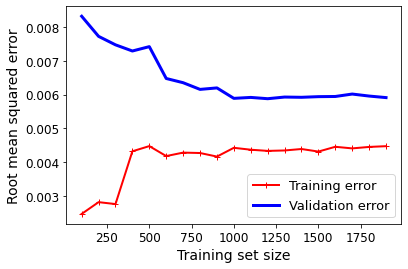

In [75]:
plot_learning_curves(nl_svm_all, dataset_prepared_stand, dataset_labels)

### Export model

In [78]:
ml_model = nl_svm_all
feats = features
pipeline = transformation_pipeline

#### For ABM

In [67]:
import csv
from numpy import savetxt 

def export_model_for_abm(ml_model, feats, pipeline, folder_path):
    scaler = StandardScaler() # Needs to be instantiated to be passed to the ABM if not fit in its initialization
    dataset_only_transf = pipeline.fit_transform(dataset) ##
    scaler.fit(dataset_only_transf)
    model_for_abm = Pipeline([
        ("scaling", scaler),
        ("regressor", ml_model)
    ])
    joblib.dump(model_for_abm, os.path.join(folder_path, 'model.pkl'))
    # Check
    print(model_for_abm.predict(dataset_only_transf[0, :].reshape(1, -1))[0])
    
    #Export features name
    with open(os.path.join(folder_path, 'features.csv'), "w+") as file:
        wr = csv.writer(file)
        wr.writerow(feats)
    
    savetxt(os.path.join(folder_path, 'dataset.csv'), dataset_only_transf, delimiter=',')
    savetxt(os.path.join(folder_path, 'labels.csv'), dataset_labels.values,  delimiter=',') ##

In [80]:
folder_path = './Models for ABM/all_adoption/regressor'

In [81]:
export_model_for_abm(ml_model, feats, pipeline, folder_path)

0.0018124758813949197


#### For model analysis

In [ ]:
joblib.dump(ml_model, './Models to analyse/all_adoption/regressor/nl_svm.pkl')